<a href="https://colab.research.google.com/github/vanesalinas/HenryPI_MLOps_PT09/blob/main/EDA_Sistema_de_Recomendacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analisis Exploratorio de Datos

---

El analisis exploratorio de datos (EDA) es muy importante para comprender los datos que tenemos antes de crear un modelo de aprendizaje automatico. Se realizara una exploracion visual y estadistica de los patos para descubrir patrones, anomalias y tendencias, entre otros. Esto ayudara a entender mejor la base de datos y a identificar las caracteristicas mas relevantes para las recomendaciones que otrorgara el modelo.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import scipy
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
!pip install nltk
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Vistazo general de la estructura de los datos

Se cargan los datos en un dataframe y se examina el mismo.

- estadisticas descriptivas (.describe()):
    - Medidas de tendencia central para variables numericas (media, mediana, moda)
    - Medidas de dispercion
    - Frecuencias para variables categoricas

In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/Datasets/modelo_df.parquet', engine='pyarrow')

In [ ]:
# Se imprimen los primeros registros para verificar que se cargaron bien los datos
df.head()

,id,overview,popularity,release_date,title,vote_average,vote_count,genres_names,production_companies_names,production_countries_names,return,actor_name,director_name
0,862.0,"Led by Woody, Andy's toys live happily in his ...",21.95,1995-10-30,Toy Story,7.7,5415.0,"[Animation, Comedy, Family]",[Pixar Animation Studios],[United States of America],12.45,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",John Lasseter
1,8844.0,When siblings Judy and Peter discover an encha...,17.02,1995-12-15,Jumanji,6.9,2413.0,"[Adventure, Fantasy, Family]","[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America],4.04,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",Joe Johnston
2,15602.0,A family wedding reignites the ancient feud be...,11.71,1995-12-22,Grumpier Old Men,6.5,92.0,"[Romance, Comedy]","[Warner Bros., Lancaster Gate]",[United States of America],0.00,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",Howard Deutch
3,31357.0,"Cheated on, mistreated and stepped on, the wom...",3.86,1995-12-22,Waiting to Exhale,6.1,34.0,"[Comedy, Drama, Romance]",[Twentieth Century Fox Film Corporation],[United States of America],5.09,"[Whitney Houston, Angela Bassett, Loretta Devi...",Forest Whitaker
4,11862.0,Just when George Banks has recovered from his ...,8.39,1995-02-10,Father of the Bride Part II,5.7,173.0,[Comedy],"[Sandollar Productions, Touchstone Pictures]",[United States of America],0.00,"[Steve Martin, Diane Keaton, Martin Short, Kim...",Charles Shyer


In [ ]:
# Se verifica el tamaño de la base de datos
df.shape

(46723, 13)

In [ ]:
# Informacion general del dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46723 entries, 0 to 46722
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id                          46723 non-null  float64       
 1   overview                    45840 non-null  object        
 2   popularity                  46723 non-null  float64       
 3   release_date                46723 non-null  datetime64[ns]
 4   title                       46723 non-null  object        
 5   vote_average                46723 non-null  float64       
 6   vote_count                  46723 non-null  float64       
 7   genres_names                46723 non-null  object        
 8   production_companies_names  46723 non-null  object        
 9   production_countries_names  46723 non-null  object        
 10  return                      46723 non-null  float64       
 11  actor_name                  46723 non-null  object    

In [ ]:
# Resumen estadistico para campos numericos
df.describe()

,id,popularity,release_date,vote_average,vote_count,return
count,46723.000000,46723.000000,46723,46723.000000,46723.000000,4.672300e+04
mean,104604.022023,3.114807,1992-03-26 20:22:20.975536640,5.693389,117.950260,6.412158e+02
min,2.000000,0.000000,1878-06-14 00:00:00,0.000000,0.000000,0.000000e+00
25%,25238.000000,0.470000,1978-03-10 00:00:00,5.100000,4.000000,0.000000e+00
50%,56558.000000,1.260000,2001-08-18 00:00:00,6.000000,11.000000,0.000000e+00
75%,146046.000000,4.100000,2010-12-29 12:00:00,6.800000,38.000000,0.000000e+00
max,469172.000000,547.490000,2020-12-16 00:00:00,10.000000,14075.000000,1.239638e+07
std,111063.225091,6.691715,NaN,1.804206,506.792214,7.360880e+04


In [ ]:
# Descripcion de las columnas no numericas
df.describe(include=['O'])

## Limpieza de datos

- Corregir tipo de datos

In [ ]:
# Se revisa si existe registros duplicados
df.duplicated(subset='id').sum()

4170

In [ ]:
# Eliminar filas duplicadas basándonos en la columna 'id'
df.drop_duplicates(subset='id', keep='first', inplace=True)  # Mantener el primer duplicado

In [ ]:
# Verificar si se eliminaron los duplicados
df.duplicated(subset='id').sum()

0

In [ ]:
# Cantidad de nulos
df.isnull().sum()

,0
id,0
overview,828
popularity,0
release_date,0
title,0
vote_average,0
vote_count,0
genres_names,0
production_companies_names,0
production_countries_names,0


La unica columna con datos nulos es 'overview', los cuales se rellenaran con un '-' para identificar la ausencia de una reseña.

In [ ]:
df['overview'].fillna('-', inplace=True)

In [ ]:
df.isnull().any()

,0
id,False
overview,False
popularity,False
release_date,False
title,False
vote_average,False
vote_count,False
genres_names,False
production_companies_names,False
production_countries_names,False


## Visualizacion y exploracion de los datos

- Boxplot para identificar outliers
- Matriz de correlacion para identificar la relacion entre variables numericas
    - Correlacion de Pearson
    - Correlacion de Spearman
- Graficos de dispersion para evaluar relaciones entre pares de variables numericas
- Grafico de barras para visualizar la frecuencia de las variables categoricas
- NetworkX para visualizar relaciones entre variables categoricas
- Analisis de series temporales para visualizar como han cambiado las variables a lo largo del tiempo.
- Nuve de palabras para obtener insights sobre las palabras mas comunes.

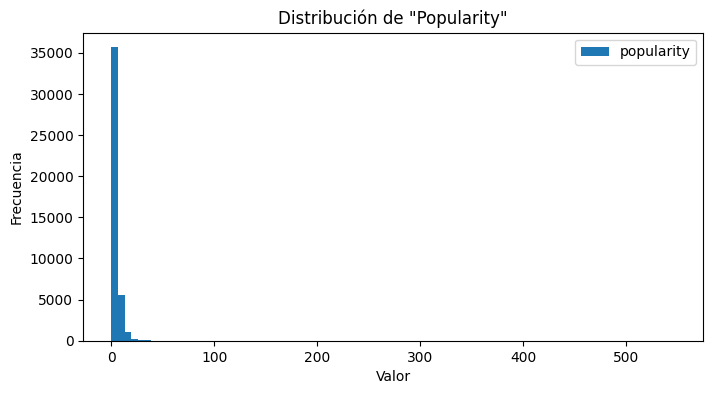

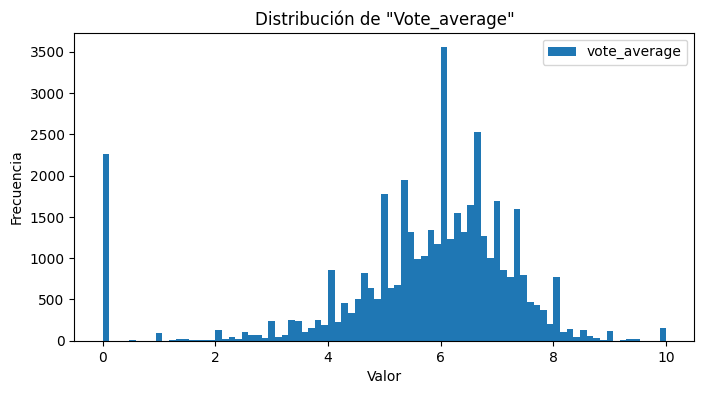

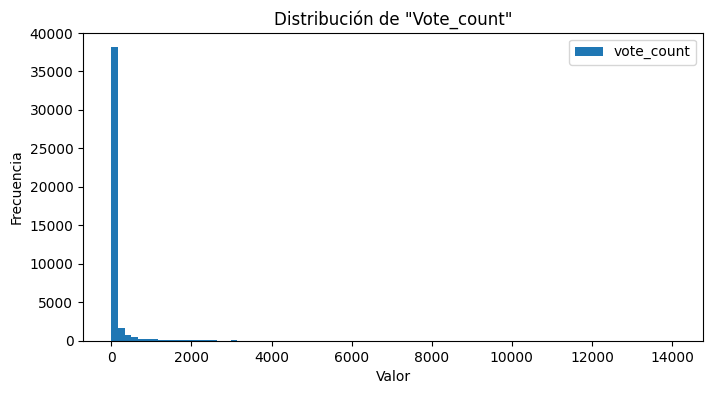

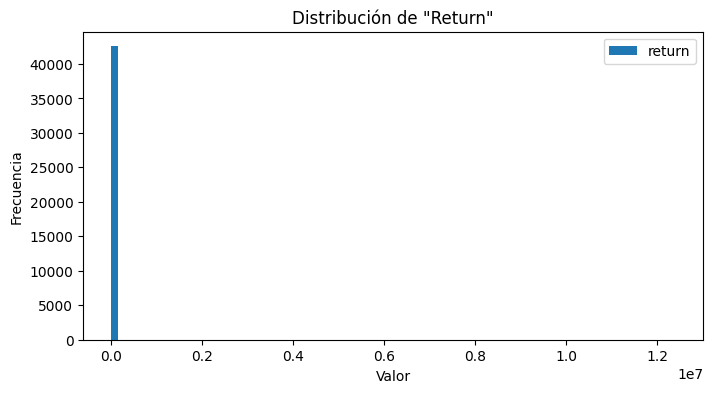

In [ ]:
# Histogramas para entender la distribucion de variables numericas
variables_numericas = ['popularity', 'vote_average', 'vote_count','return']

for col in variables_numericas:
    plt.figure(figsize=(8, 4))
    plt.hist(df[col], bins=85, label=col)
    plt.xlabel('Valor')
    plt.ylabel('Frecuencia')
    plt.title(f'Distribución de "{col.capitalize()}"')
    plt.legend()
    plt.show()

In [ ]:
df['return'].dtype

dtype('float64')

In [ ]:
df['return'].describe()

count    4.255300e+04
mean     7.038289e+02
std      7.713097e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.239638e+07
Name: return, dtype: float64

In [ ]:
df['return'].sort_values()

23239           0.00
30710           0.00
30711           0.00
30712           0.00
30713           0.00
            ...     
2421      1018619.28
23426     2755584.00
15210     4197476.62
3512      8500000.00
4207     12396383.00
Name: return, Length: 42553, dtype: float64

In [ ]:
# Contamos el número de registros con valor 0.0 en la columna 'return'
df['return'].eq(0.0).sum()

37251

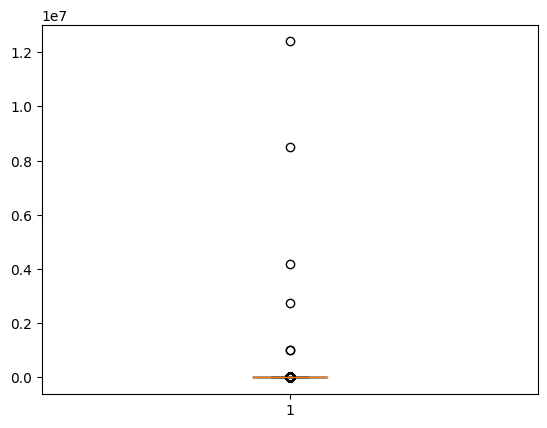

In [ ]:
# Boxplot
plt.boxplot(df['return'])
plt.show()

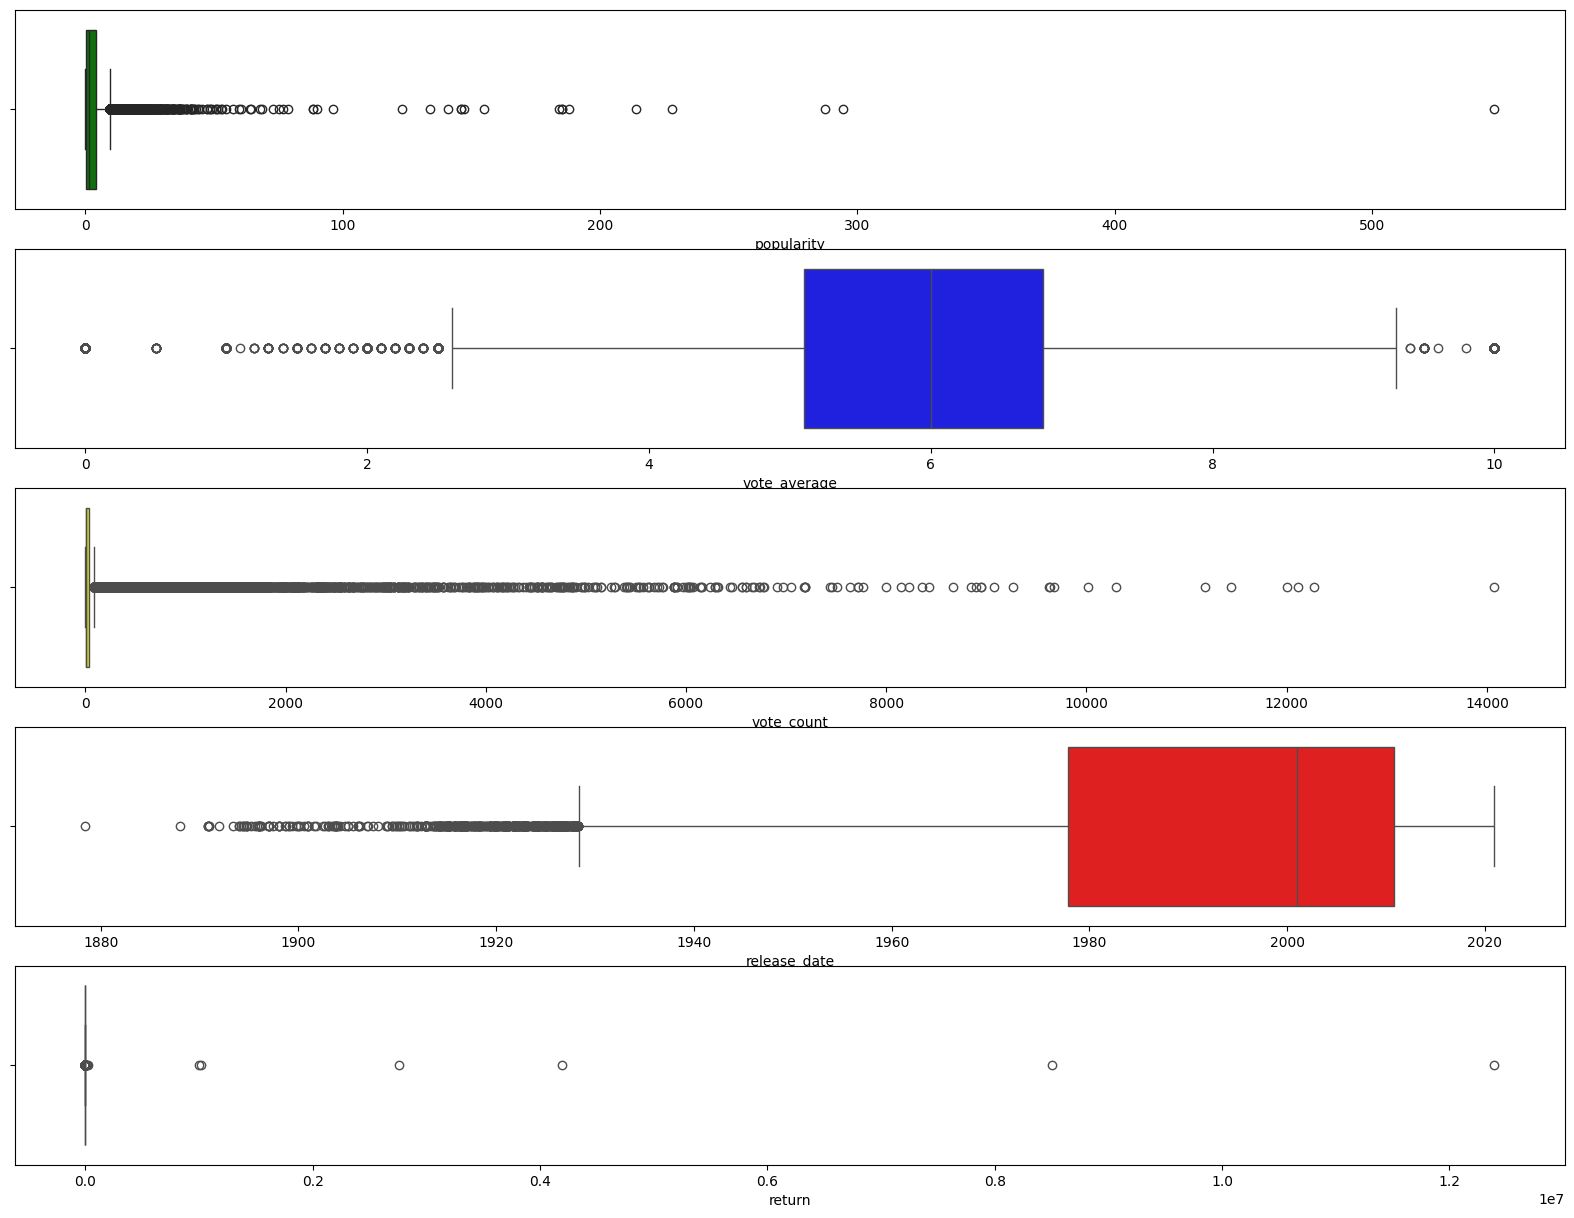

In [ ]:
# Boxplot para identificar outliers

# Se hace graficas de cajas y bigotes para establcer los outliers de las variables numericas
plt.figure(figsize= (20,15))
plt.subplot(5,1,1)
sns.boxplot(x= df.popularity, color='green')

plt.subplot(5,1,2)
sns.boxplot(x= df.vote_average, color='blue')

plt.subplot(5,1,3)
sns.boxplot(x= df.vote_count, color='yellow')

plt.subplot(5,1,4)
sns.boxplot(x= df.release_date, color='red')

plt.subplot(5,1,5)
sns.boxplot(x= df['return'], color='orange')

plt.show()


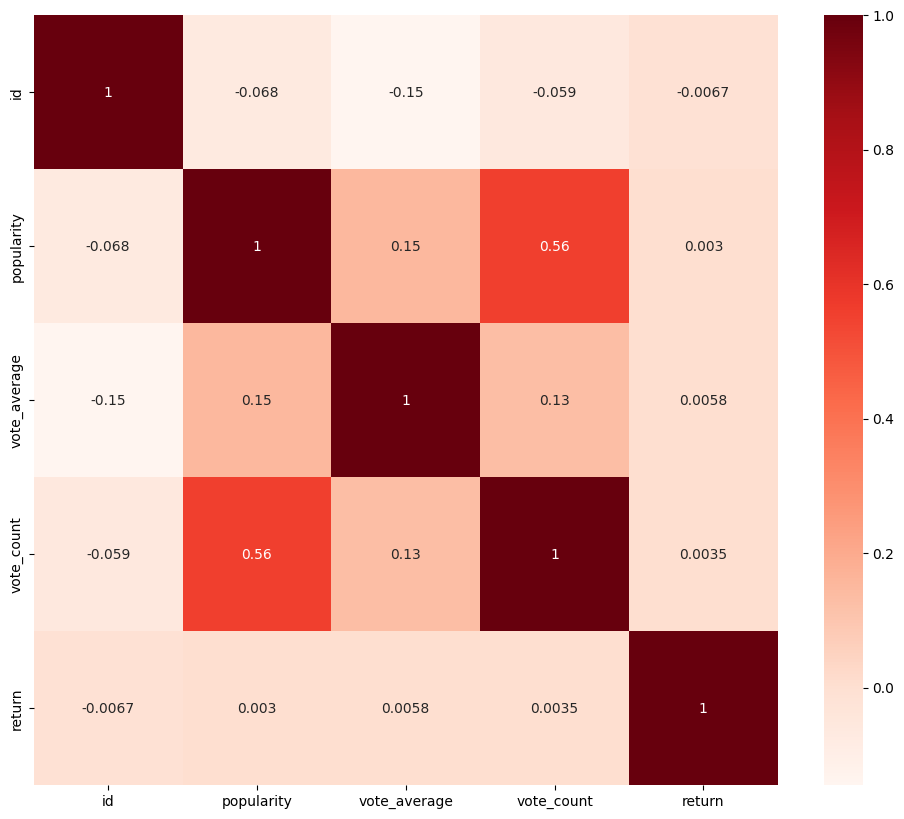

In [ ]:
# Matriz de correlacion para identificar la relacion entre variables numericas

plt.figure(figsize=(12,10))

# Seleccionamos solo las columnas numéricas para el cálculo de la correlación
cor = df.select_dtypes(include=['number']).corr()

sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()


In [ ]:
# Encontrar las películas más populares:

# Ordenar el conjunto de datos por la columna de popularidad en orden descendente:
peliculas_populares = df.sort_values('popularity', ascending=False)

# Mostrar las 10 primeras películas en la lista
top_peliculas = peliculas_populares.head(10)
top_peliculas[['title', 'popularity']]


,title,popularity
32044,Minions,547.49
34785,Wonder Woman,294.34
43518,Beauty and the Beast,287.25
44920,Baby Driver,228.03
25627,Big Hero 6,213.85
27826,Deadpool,187.86
27828,Guardians of the Galaxy Vol. 2,185.33
15388,Avatar,185.07
25528,John Wick,183.87
24853,Gone Girl,154.80


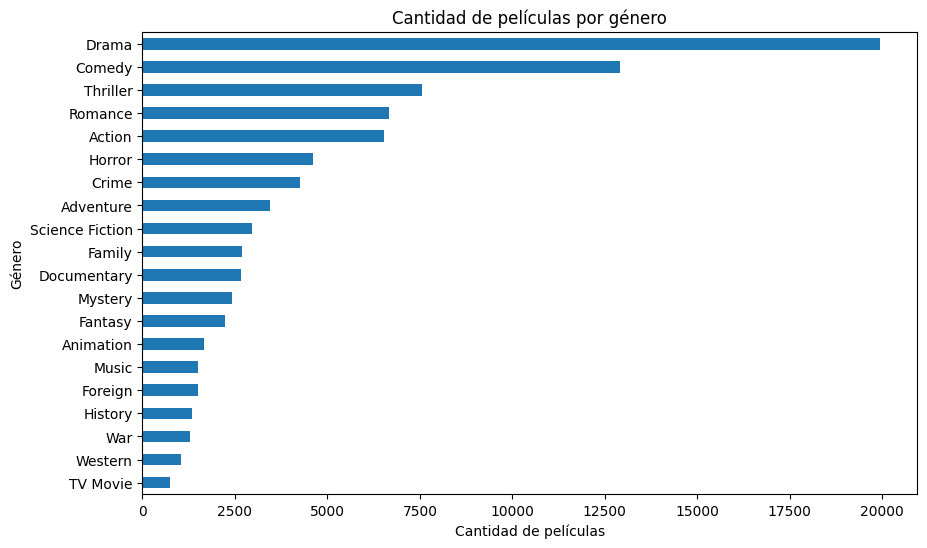

In [ ]:
# Grafico para ver la cantidad de peliculas por genero

# Dividimos la lista de géneros, contamos y ordenamos los valores para que el grafico se vea mejor
generos_counts = df.explode('genres_names')['genres_names'].value_counts().sort_values()

plt.figure(figsize=(10,6))
generos_counts.plot(kind='barh')
plt.title('Cantidad de películas por género')
plt.xlabel('Cantidad de películas')
plt.ylabel('Género')
plt.show()

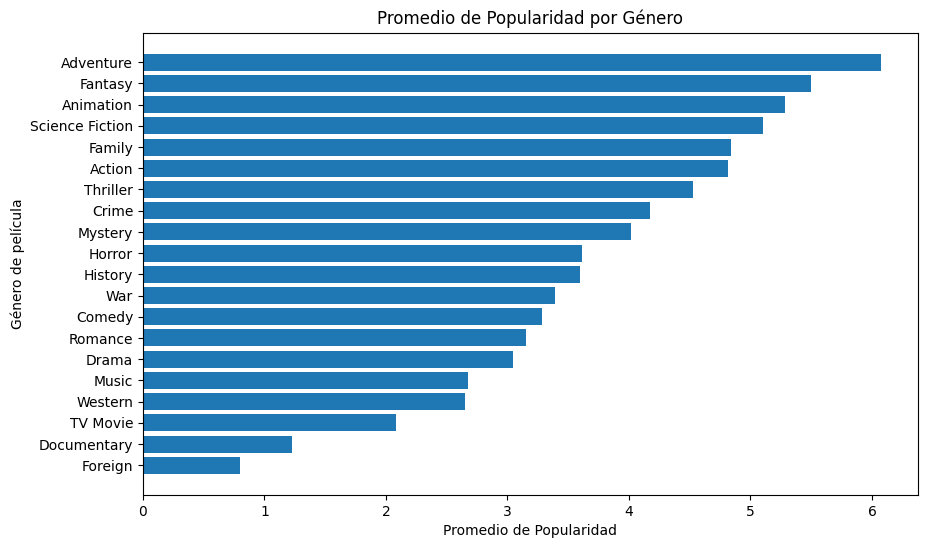

In [ ]:
# Calcular el promedio de popularidad por género y ordenamos los valores
promedio_popularidad = df.explode('genres_names').groupby('genres_names')['popularity'].mean().sort_values()

# Obtener los géneros y los promedios de popularidad
generos = promedio_popularidad.index.tolist()
promedio = promedio_popularidad.tolist()

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(generos, promedio)
ax.set_ylabel('Género de película')
ax.set_xlabel('Promedio de Popularidad')
ax.set_title('Promedio de Popularidad por Género')

plt.show()

Text(0.5, 1.0, 'Top 10 - Productoras con más películas')

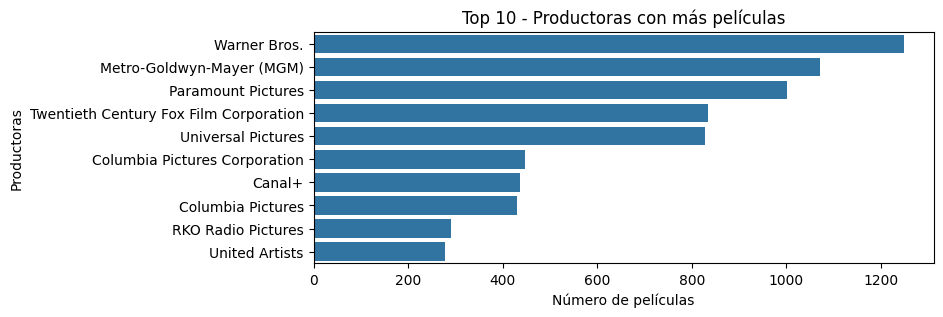

In [ ]:
# Determinar las productoras que producen mayor cantidad de películas:

# Dividimos las productoras y agrupamos el conjunto de datos
productoras = df.explode('production_companies_names').groupby('production_companies_names')['id'].count().reset_index()

# Ordenar los resultados para ver cuales son las productoras con mas peliculas
productoras = productoras.sort_values('id', ascending=False)

# Visualizar los resultados, por ejemplo, las 10 principales productoras con más películas
top_10 = productoras.head(10)
plt.figure(figsize=(8, 3))
sns.barplot(y='production_companies_names', x='id', data=top_10)
plt.ylabel('Productoras')
plt.xlabel('Número de películas')
plt.title('Top 10 - Productoras con más películas')

Text(0.5, 1.0, 'Paises donde mas peliculas se producen')

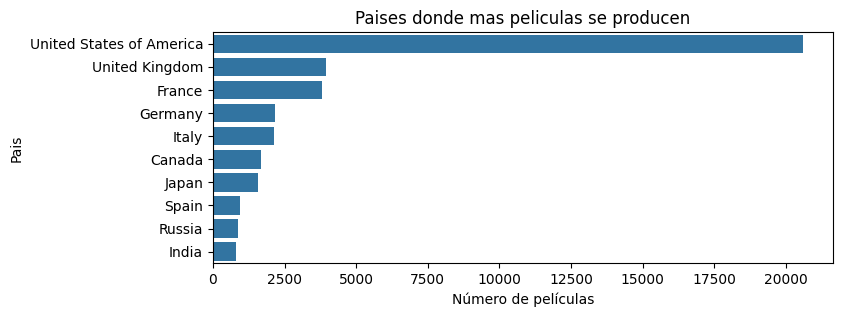

In [ ]:
# Determinar los paises donde mas se producen películas:

# Dividimos los paises y agrupamos el conjunto de datos
paises_productores = df.explode('production_countries_names').groupby('production_countries_names')['id'].count().reset_index()

# Ordenar los resultados
paises_productores = paises_productores.sort_values('id', ascending=False)

# Visualizar los resultados, por ejemplo, las 10 principales productoras con más películas
top_10 = paises_productores.head(10)
plt.figure(figsize=(8, 3))
sns.barplot(y='production_countries_names', x='id', data=top_10)
plt.ylabel('Pais')
plt.xlabel('Número de películas')
plt.title('Paises donde mas peliculas se producen')

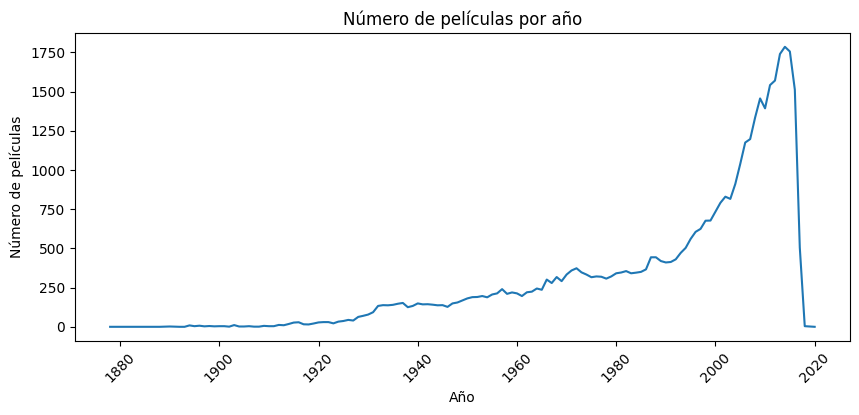

In [ ]:
# Graficar el numero de peliculas en funcion del año

# Agrupar por año y contar el numero de peliculas
total_peliculas = df['release_date'].dt.year.value_counts().sort_index()

# Crear el grafico
plt.figure(figsize=(10, 4))
sns.lineplot(x=total_peliculas.index, y=total_peliculas.values)
plt.xticks(rotation=45)

plt.xlabel('Año')
plt.ylabel('Número de películas')
plt.title('Número de películas por año')

plt.show()

In [ ]:
df['release_date'].dt.year.value_counts().sort_values()

release_date
2020       1
1888       1
1893       1
1892       1
1878       1
        ... 
2011    1541
2012    1570
2013    1739
2015    1755
2014    1785
Name: count, Length: 132, dtype: int64

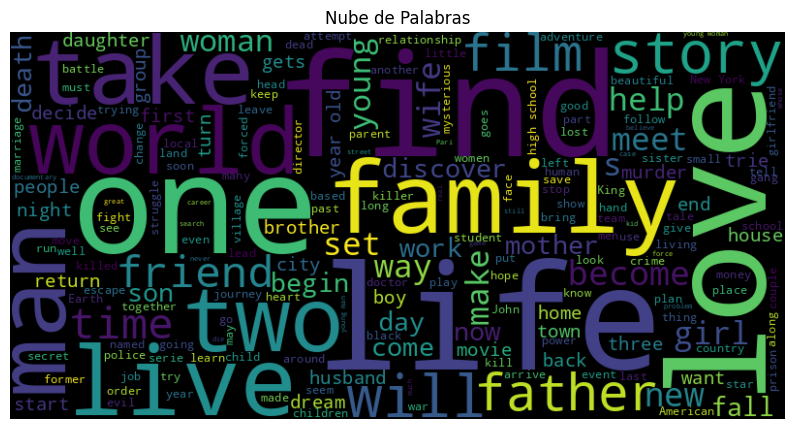

In [ ]:
# Nube de palabras

# Crear una nueva columna para concatenar overview y title.
df['nube_palabras'] = df['overview'] + ' ' + df['title']

# Unir todo el texto en una sola cadena
texto = ' '.join(df['nube_palabras'].apply(lambda x: str(x)))

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='viridis', max_font_size=150).generate(texto)

# Visualizar la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras')
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42553 entries, 0 to 46722
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id                          42553 non-null  float64       
 1   overview                    42553 non-null  object        
 2   popularity                  42553 non-null  float64       
 3   release_date                42553 non-null  datetime64[ns]
 4   title                       42553 non-null  object        
 5   vote_average                42553 non-null  float64       
 6   vote_count                  42553 non-null  float64       
 7   genres_names                42553 non-null  object        
 8   production_companies_names  42553 non-null  object        
 9   production_countries_names  42553 non-null  object        
 10  return                      42553 non-null  float64       
 11  actor_name                  42553 non-null  object        


## Preparacion para el modelado

Preparar los datos para alimentar el modelo de aprendizaje automatico.
- Codificacion de variables categoricas
- Normalizacion de variables numericas
- Division de datos en conjuntos de entrenamiento y prueba.

In [ ]:
# Como la cantidad de resgistros, incluso despues de eliminar los nulos sigue siendo muy grande para ejecutar el entrenamiento del modelo
# se toma la determinacion de hacerla mas pequeña en base a las columnas "vote_average" y "popularity", de manera que primero se seleccionan
# los 20000 registros mejor puentuados en las columana "vote_average" y luego a partir de los 20000 registros se seleccionan los 10000 mejor
# puntuados segun la columna 'popularity'

In [ ]:
df.iloc[0]

id                                                                        862.0
overview                      Led by Woody, Andy's toys live happily in his ...
popularity                                                                21.95
release_date                                                1995-10-30 00:00:00
title                                                                 Toy Story
vote_average                                                                7.7
vote_count                                                               5415.0
genres_names                                        [Animation, Comedy, Family]
production_companies_names                            [Pixar Animation Studios]
production_countries_names                           [United States of America]
return                                                                    12.45
actor_name                    [Tom Hanks, Tim Allen, Don Rickles, Jim Varney...
director_name                           

In [ ]:
# limitamos la base de datos unicamnete a las peliculas posteriores al año 2000 para poder generar una mejor lectura de los datos
df_modelo = df[df['release_date'].dt.year >= 1990]
df_modelo.head()

,id,overview,popularity,release_date,title,vote_average,vote_count,genres_names,production_companies_names,production_countries_names,return,actor_name,director_name,nube_palabras
0,862.0,"Led by Woody, Andy's toys live happily in his ...",21.95,1995-10-30,Toy Story,7.7,5415.0,"[Animation, Comedy, Family]",[Pixar Animation Studios],[United States of America],12.45,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",John Lasseter,"Led by Woody, Andy's toys live happily in his ..."
1,8844.0,When siblings Judy and Peter discover an encha...,17.02,1995-12-15,Jumanji,6.9,2413.0,"[Adventure, Fantasy, Family]","[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America],4.04,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",Joe Johnston,When siblings Judy and Peter discover an encha...
2,15602.0,A family wedding reignites the ancient feud be...,11.71,1995-12-22,Grumpier Old Men,6.5,92.0,"[Romance, Comedy]","[Warner Bros., Lancaster Gate]",[United States of America],0.00,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",Howard Deutch,A family wedding reignites the ancient feud be...
3,31357.0,"Cheated on, mistreated and stepped on, the wom...",3.86,1995-12-22,Waiting to Exhale,6.1,34.0,"[Comedy, Drama, Romance]",[Twentieth Century Fox Film Corporation],[United States of America],5.09,"[Whitney Houston, Angela Bassett, Loretta Devi...",Forest Whitaker,"Cheated on, mistreated and stepped on, the wom..."
4,11862.0,Just when George Banks has recovered from his ...,8.39,1995-02-10,Father of the Bride Part II,5.7,173.0,[Comedy],"[Sandollar Productions, Touchstone Pictures]",[United States of America],0.00,"[Steve Martin, Diane Keaton, Martin Short, Kim...",Charles Shyer,Just when George Banks has recovered from his ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46717,289923.0,A film archivist revisits the story of Rustin ...,0.39,2000-10-03,The Burkittsville 7,7.0,1.0,[Horror],"[Neptune Salad Entertainment, Pirie Productions]",[United States of America],0.00,"[Monty Bane, Lucy Butler, David Grammer, Bill ...",Ben Rock,A film archivist revisits the story of Rustin ...
46718,222848.0,It's the year 3000 AD. The world's most danger...,0.66,1995-01-01,Caged Heat 3000,3.5,1.0,[Science Fiction],[Concorde-New Horizons],[United States of America],0.00,"[Lisa Boyle, Kena Land, Zaneta Polard, Don Yan...",Aaron Osborne,It's the year 3000 AD. The world's most danger...
46719,30840.0,"Yet another version of the classic epic, with ...",5.68,1991-05-13,Robin Hood,5.7,26.0,"[Drama, Action, Romance]","[Westdeutscher Rundfunk (WDR), Working Title F...","[Canada, Germany, United Kingdom, United State...",0.00,"[Patrick Bergin, Uma Thurman, David Morrissey,...",John Irvin,"Yet another version of the classic epic, with ..."
46720,111109.0,An artist struggles to finish his work while a...,0.18,2011-11-17,Century of Birthing,9.0,3.0,[Drama],[Sine Olivia],[Philippines],0.00,"[Angel Aquino, Perry Dizon, Hazel Orencio, Joe...",Lav Diaz,An artist struggles to finish his work while a...


Preparar los datos para alimentar el modelo de aprendizaje automatico.

+ Limpieza de texto: eliminar stopwords
+ Vectorización: Convertir texto en vectores numéricos
+ Creación de una matriz de características: Combinar las diferentes características de las peliculas en una única matriz.

In [ ]:
# Limpieza y vectorización
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_modelo['nube_palabras'])

# Seleccionar las columnas para la lista de caracteristicas
features = ['genres_names', 'production_companies_names', 'production_countries_names', 'actor_name', 'director_name'] # Usar directamente los nombres de las columnas

for feature in features:
    # Manejar listas en las columnas
    df_modelo[feature] = df_modelo[feature].apply(lambda x: x if isinstance(x, list) else []) # Asegurar que todas las celdas contienen listas
    #df[feature] = df[feature].apply(lambda x: x if x else ['']) # Reemplazar listas vacías con una lista que contiene una cadena vacía

        # Unir elementos de la lista para tfidf y agregar al vocabulario existente
    #tfidf.fit(df[feature].apply(lambda x: ' '.join(x))) # Ajustar el vocabulario con los nuevos términos
    tfidf_matrix = scipy.sparse.hstack((tfidf_matrix, tfidf.transform(df_modelo[feature].apply(lambda x: ' '.join(x))))) # Transformar y agregar al tfidf_matrix existente

<ipython-input-14-6348d24350d3>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo[feature] = df_modelo[feature].apply(lambda x: x if isinstance(x, list) else []) # Asegurar que todas las celdas contienen listas


## Modelo de aprendizaje: Sistema de recomendacion

Los algoritmos de recomendacion analizan la informacion de los usuarios y los elementos para predecir qué elementos seran del agardo de un usuario en particular.
Se basan en diferentes tecnicas pero en general se pueden clasificar en dos categorias principales:
- Filtrado colaborativo
    - Recomienda elementos que han gustado a usuarios similares.
    - Recomienda elementos similares a los que le han gustado al usuario en el pasado.
- Filtrado basado en contenido
    - Recomienda elementos similares a los que el usuario ha interactuado anteriormente, basandose en las caracteristicas de estos elementos.

Algoritmos especificos
- K-Nearest Neighnors(KNN): encuentra los k elementos mas similares a un elemento objetivo y recomienda los elementos mas populares entre esos vecinos.
- Matrix Factorization: descompone una matriz de calificaciones de usuarios y elementos en matrices de factores latentes para encontrar patrones y hacer recomendaciones.
- Modelos de topicos: identifica temas y recomienda elementos relacionados con los temas que interesan al usuario.
- Redes neuronales: modelos mas complejos que pueden capturar relaciones no lineales entre usuarios y elementos.

In [ ]:
# Calcular la similitud del coseno entre todas las películas
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Crear un diccionario que mapee los títulos de las películas a sus índices
indices = pd.Series(df_modelo.index, index=df_modelo['title']).drop_duplicates()

In [ ]:
def recommend_movies(title, cos_sim=cosine_sim, data=df_modelo, num_recommendations=5):
    # Encontrar el índice de la película
    idx = indices[title]

    # Obtener las películas más similares
    sim_scores = list(enumerate(cos_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:num_recommendations+1]

    # Obtener los índices de las películas más similares
    movie_indices = [i[0] for i in sim_scores]

    # Retornar los títulos de las películas recomendadas
    return data['title'].iloc[movie_indices]

In [ ]:
# Recomendar 5 películas similares a "Inception"
recommended_movies = recommend_movies('Toy Story')
recommended_movies

,title
16275,Toy Story 3
3147,Toy Story 2
25692,Small Fry
10808,The 40 Year Old Virgin
44023,Andy Peters: Exclamation Mark Question Point
